### Agentic RAG

In [9]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitterss
from langchain_huggingface import HuggingFaceEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [11]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')]]

In [12]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings()
)


retriever=vectorstore.as_retriever()

In [13]:
retriever.invoke("what is langgraph")

[Document(id='039dbdae-a349-4a8a-8c13-52b618adcde4', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='Redirecting...\n\n\n\n\n\n\nRedirecting...'),
 Document(id='9b9200d4-68e9-4561-9fde-029229d9993b', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Redirecting...', 'language': 'en'}, page_content='Redirecting...\n\n\n\n\n\n\nRedirecting...'),
 Document(id='013efafc-5928-4d61-b868-c060dfa6b4b4', metadata={'source': 'https://langchain-ai.github.io/langgraph/how-tos/map-reduce/', 'title': 'Redirecting...', 'language': 'en'}, page_content='Redirecting...\n\n\n\n\n\n\nRedirecting...')]

In [14]:
### Retriever To Retriever Tools
from langchain_core.tools import create_retriever_tool



retriever_tool=create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [15]:
retriever_tool

StructuredTool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x000002485840B560>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x00000248198E1E40>)

### Langchain Blogs- Seperate Vector Store


In [16]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'LangChain overview - Docs by LangChain', 'description': 'LangChain is an open source framework with a pre-built agent architecture and integrations for any model or tool — so you can build agents that adapt as fast as the ecosystem evolves', 'language': 'en'}, page_content='LangChain overview - Docs by LangChainSkip to main contentDocs by LangChain home pageOpen sourceSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChain overviewDeep AgentsLangChainLangGraphIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartChangelogPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewPrebuilt middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engineeringModel Context Protocol (MCP)Human-in-the-loopMulti-agentRetrievalLong-term memoryAgent developmentLangSmith StudioTestAgent Chat UIDeploy wit

In [17]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstorelangchain=FAISS.from_documents(
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings()
)


retrieverlangchain=vectorstorelangchain.as_retriever()

In [18]:
from langchain_core.tools import create_retriever_tool

retriever_tool_langchain=create_retriever_tool(
    retrieverlangchain,
    "retriever_vector_langchain_blog",
    "Search and run information about Langchain"
)

In [19]:
import os
import requests
from langchain.tools import tool

@tool
def get_weather(city: str) -> str:
    """Get current weather for a given city."""
    
    api_key = os.getenv("WEATHER_API_KEY")
    if not api_key:
        return "Weather API key not set"

    url = f"https://api.weatherapi.com/v1/current.json?key={api_key}&q={city}"
    resp = requests.get(url)
    data = resp.json()

    if "error" in data:
        return f"Weather API error: {data['error']['message']}"

    return f"{data['location']['name']} is {data['current']['temp_c']}°C"

get_weather.invoke({"city": "bengaluru"})


'Bengaluru is 19.3°C'

In [53]:
tools=[retriever_tool,retriever_tool_langchain,get_weather]

In [54]:
tools

[StructuredTool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x000002485840B560>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x00000248198E1E40>),
 StructuredTool(name='retriever_vector_langchain_blog', description='Search and run information about Langchain', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x00000248585B0860>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x00000248585B09A0>),
 StructuredTool(name='get_weather', description='Get current weather for a given city.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x0000024835074C20>)]

### LangGraph Workflow

In [55]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [56]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-120b")
llm.invoke("hi")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "hi". We just respond politely. Probably a greeting.'}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 72, 'total_tokens': 106, 'completion_time': 0.071503218, 'completion_tokens_details': {'reasoning_tokens': 16}, 'prompt_time': 0.002912243, 'prompt_tokens_details': None, 'queue_time': 0.046104484, 'total_time': 0.074415461}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c681e-9157-7e90-b831-eafba986fd80-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 72, 'output_tokens': 34, 'total_tokens': 106, 'output_token_details': {'reasoning': 16}})

In [72]:
def agent(state):
    """
    Invokes the agent model to generate a response based on current state. Given the question, it will decide to retrieve using 
    the retriever tools, for weather related questions use get_weather tool.
    
    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the response added to the messages
    
    
    """
    
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="openai/gpt-oss-120b")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {
        "messages": messages + [response]
        }


In [60]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_classic import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [61]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="openai/gpt-oss-120b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [62]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="openai/gpt-oss-120b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [63]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="openai/gpt-oss-120b")
    response = model.invoke(msg)
    return {"messages": [response]}

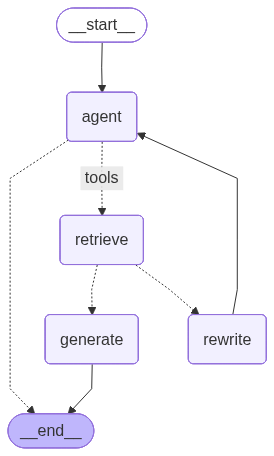

In [64]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool,retriever_tool_langchain,get_weather])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [65]:
graph.invoke({"messages": [HumanMessage(content="What is LangGraph?")]})

---CALL AGENT---


{'messages': [HumanMessage(content='What is LangGraph?', additional_kwargs={}, response_metadata={}, id='f9dec876-e7cd-44ee-ae75-bd0f3ac034fb'),
  AIMessage(content='**LangGraph** is an open‑source Python library (maintained by the LangChain team) that lets you build **graph‑structured, stateful workflows** for large‑language‑model (LLM) applications.  \n\nIn short, it gives you a **“programming model”** for orchestrating LLM calls, tool usage, memory, branching, loops, and conditional logic—everything you need to turn a prompt into a full‑featured, production‑ready application.\n\n---\n\n## Why LangGraph Exists\n\n| Problem in LLM Apps | How LangGraph Helps |\n|----------------------|----------------------|\n| **Linear prompt‑to‑output pipelines** feel brittle when you need retries, branching, or multiple tool calls. | You model the workflow as a **graph** of nodes (steps) and edges (transitions), so the execution can naturally branch, loop, or backtrack. |\n| **State management** (e.

In [66]:
graph.invoke({"messages": "what is machine learning"})

---CALL AGENT---


{'messages': [HumanMessage(content='what is machine learning', additional_kwargs={}, response_metadata={}, id='9255a691-a86c-439d-95a9-cd2dfcc0bf01'),
  AIMessage(content='**Machine learning (ML)** is a subfield of artificial intelligence (AI) that focuses on building systems that can **learn from data** and improve their performance on a task without being explicitly programmed for every possible situation.\n\n### Core Idea\n- **Traditional programming**: You write explicit rules (if‑else statements) that tell a computer exactly what to do.\n- **Machine learning**: You give the computer **examples** (data) and a **goal** (e.g., predict a label, generate text, control a robot). The computer automatically discovers patterns in the data and creates a model that can make predictions or decisions on new, unseen data.\n\n### How It Works (Simplified)\n1. **Collect Data** – Gather a dataset that represents the problem (e.g., images of cats and dogs, historical stock prices, user click logs).

In [67]:
graph.invoke({"messages": "weather in bengaluru"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='weather in bengaluru', additional_kwargs={}, response_metadata={}, id='edcb3e71-c94a-48e4-a173-c0cfb294447d'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to get weather for Bengaluru using get_weather tool.', 'tool_calls': [{'id': 'fc_8a806ba7-6db3-4d9d-8864-c112f48f3c80', 'function': {'arguments': '{"city":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 195, 'total_tokens': 238, 'completion_time': 0.097119056, 'completion_tokens_details': {'reasoning_tokens': 13}, 'prompt_time': 0.041282642, 'prompt_tokens_details': None, 'queue_time': 0.049806287, 'total_time': 0.138401698}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_d29d1d1418', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c6820-ad64-7043-a8f4-f87a19613129-0', tool_calls=[{'name': 'get

In [68]:
#EVAL

EVAL_SET = [
    {
        "question": "what is langchain?",
        "expected_keywords": ["langchain"]
    },
    {
        "question": "what is langgraph?",
        "expected_keywords": ["langgraph"]
    },
    {
        "question": "What is the weather in Delhi?",
        "expected_keywords": ["Delhi", "°C"]
    }
]


In [79]:
from langchain_core.messages import HumanMessage

def call_agent(question: str):
    # initial state for your agent
    state = {
        "messages": [HumanMessage(content=question)]
    }

    final_state = graph.invoke(state)

    # last message is model output
    last_message = final_state["messages"][-1]

    return last_message.content

In [80]:
def run_eval(eval_set):
    passed = 0
    results = []

    for item in eval_set:
        q = item["question"]
        expected = item["expected_keywords"]

        print(f"\nQ: {q}")
        answer = call_agent(q)
        print(f"A: {answer}")

        score = all(word.lower() in answer.lower() for word in expected)

        if score:
            print("✅ PASS")
            passed += 1
        else:
            print("❌ FAIL")

        results.append({
            "question": q,
            "answer": answer,
            "passed": score
        })

    accuracy = passed / len(eval_set)
    print(f"\nFinal accuracy: {accuracy * 100:.2f}%")

    return results, accuracy

results, accuracy = run_eval(EVAL_SET)



Q: what is langchain?
---CALL AGENT---
A: **LangChain** is an open‑source framework that makes it easier to build applications powered by large language models (LLMs). It provides a collection of modular building blocks—**chains**, **agents**, **memory**, **prompts**, **document loaders**, **vector stores**, **retrievers**, and more—so developers can quickly assemble complex LLM‑driven workflows without reinventing the wheel.

### Core ideas

| Concept | What it does | Typical use‑case |
|---------|--------------|-----------------|
| **Chains** | Sequentially link together components (e.g., prompt → LLM → post‑processing). | Simple pipelines like “ask a question → get answer → format”. |
| **Agents** | Decide which actions to take based on LLM output, often invoking external tools or APIs. | Chatbots that can browse the web, run code, or query a database. |
| **Memory** | Persist context across turns of a conversation so the LLM can refer back to earlier information. | Conversational 

In [71]:
results, accuracy = run_eval(EVAL_SET)



Q: what is langchain?
---CALL AGENT---
A: **LangChain** is an open‑source framework that makes it easy to build applications powered by large language models (LLMs). It provides a set of modular, composable building blocks that let developers:

| Category | What it does | Typical use‑cases |
|----------|--------------|-------------------|
| **Prompt Management** | Templates, dynamic variable injection, prompt optimization | Chatbots, summarization, Q&A |
| **LLM Wrappers** | Unified API for OpenAI, Anthropic, Cohere, HuggingFace, etc. | Switch models without changing code |
| **Chains** | Sequential or conditional pipelines that connect prompts, LLM calls, and other functions | Retrieval‑augmented generation, tool‑use workflows |
| **Agents** | LLMs that can decide which tool (e.g., search, calculator, database) to invoke and then act on the result | Autonomous assistants, code‑generation bots |
| **Memory** | State‑keeping across turns (conversation history, summaries, vector store r

In [81]:
# ===== CI ENTRYPOINT =====

results, accuracy = run_eval(EVAL_SET)

# Fail CI if accuracy is too low
if accuracy < 0.7:
    raise Exception("Evaluation accuracy below threshold")



Q: what is langchain?
---CALL AGENT---
A: **LangChain** is an open‑source framework that makes it easier to build applications powered by large language models (LLMs).  
It was created by **Richard Vlasov** and **Harrison Chase** in 2022 and has quickly become one of the most popular toolkits for developers who want to go beyond “prompt‑and‑complete” interactions and build more sophisticated, “agent‑like” systems.

---

## Why LangChain exists

LLMs are great at generating text, but most real‑world products need additional capabilities:

| Need | What you typically have to add yourself | How LangChain helps |
|------|------------------------------------------|---------------------|
| **Memory** – keep track of prior conversation turns or state | Custom data structures, vector stores, databases | Built‑in memory abstractions (ConversationBuffer, SummaryMemory, etc.) |
| **Tool use** – call APIs, run code, fetch documents | Write glue code for each tool | A unified “Tool” interface and 